# Imports


In [80]:
!pip install dijkstar

  Using cached Dijkstar-2.6.0-py3-none-any.whl (12 kB)


In [3]:
import numpy as np
# Import opencv for computer vision
import cv2 
# Import matplotlib to visualize an image
from matplotlib import pyplot as plt
from __future__ import print_function
import sys
from random import randint
import cv2.aruco as aruco


# Computer Vision


## Past attempts:

Potential solutions:
1. Using Tensorflow
https://www.youtube.com/watch?v=yqkISICHH-U

2. Using MultiTracker OpenCV
https://learnopencv.com/multitracker-multiple-object-tracking-using-opencv-c-python/

### Using MultiTracker OpenCV


Start by creating a single object tracker
- below doesnt work

Read the first frame of livestream
* May need to modify

Locate objects in the first frame

Check out
https://www.youtube.com/watch?v=8ktcGQ-XreQ

Perhaps use YOLOv5:
https://blog.paperspace.com/train-yolov5-custom-data/


https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/


## 1. Setting up Aruco

### Markers detected in real time:


Code referenced from:
https://docs.opencv.org/4.8.0/d5/dae/tutorial_aruco_detection.html

In [126]:
import cv2
import numpy as np
from cv2 import aruco

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

# Camera matrix
camera_matrix = np.array([[20.10654304, 0, 84.16362263],
                          [0, 20.34239482, 95.42267081],
                          [0, 0, 1]])

# Distortion coefficients
distortion_coefficients = np.array([[-9.40501496e-04, 3.73198946e-05, -2.32754445e-03, 3.95213785e-04, -6.01340412e-07]])

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
    parameters = aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)

    if np.all(ids is not None):
        for i in range(0, len(ids)):
            rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners[i], 0.02, camera_matrix, distortion_coefficients)
            aruco.drawDetectedMarkers(frame, corners, ids)
            cv2.drawFrameAxes(frame, camera_matrix, distortion_coefficients, rvec, tvec, 0.02)

    cv2.imshow('frame', frame)

    key = cv2.waitKey(3) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Getting marker coordinates


Thymio: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 0
<br>
Obstacles:&nbsp;&nbsp;&nbsp;indicies 1-6
<br>
Goal:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 7

In [127]:
def current_photo():
    cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
    ret, frame = cap.read()
    cv2.imwrite('images/current.jpg', frame)
    cap.release()

In [135]:
current_photo()

The following functions below retrieve the first photo, and utilize it to locate the coordinates of the markers.


In [136]:
def get_Thymio():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
 
    # Get thymio at idx 0  
    idx_back = np.where(ids == 0)[0][0]
    idx_fowards = np.where(ids == 1)[0][0]
    idx = [idx_back, idx_fowards]
    coords = [corners[i].tolist() for i in idx]  
    
    center = []
    for i in coords:
        # Get center coordinates to return
        x1 = i[0][0][0]
        y1 = i[0][0][1]
        x2 = i[0][2][0]
        y2 = i[0][2][1]

        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
    
        center.append([x_center, y_center])
    return center
    
    


In [137]:
center_thymio = get_Thymio()
print(center_thymio)

[[327.5, 164.5], [306.0, 206.0]]


In [138]:
def get_goal():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get goal at idx 7  
    idx = np.where(ids == 7)[0][0]
    coords = corners[idx]
    
      
    
    # Get center coordinates to return
    x1 = coords[0][0][0]
    y1 = coords[0][0][1]
    x2 = coords[0][2][0]
    y2 = coords[0][2][1]
    
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    
    center = [x_center, y_center]
    
    return center

In [139]:
center_goal = get_goal()
print(center_goal)

[107.5, 369.0]


In [140]:
def get_obst():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get obstacles at idx that is not Thymio or goal 
    idx = np.where((ids != 0) & (ids != 7) & (ids != 1))[0]
    coord = [corners[i].tolist() for i in idx]
    print("Coord",coord)
    id = ids[idx]
    print("ID", id)
    
    coords_list = []

    for i in coord:    
        ul_x = i[0][0][0]
        ul_y = i[0][0][1]

        ur_x = i[0][1][0]
        ur_y = i[0][1][1]

        br_x = i[0][2][0]
        br_y = i[0][2][1]

        bl_x = i[0][3][0]
        bl_y = i[0][3][1]

        coords_list.append([ul_x, ul_y, ur_x, ur_y, bl_x, bl_y, br_x, br_y])
        
    # Sort coords based on id
    coords = [x for y, x in sorted(zip(id, coords_list))]
    return coords

In [141]:
obstacle_coord = get_obst()
print(obstacle_coord)

Coord [[[[137.0, 256.0], [192.0, 256.0], [193.0, 310.0], [138.0, 311.0]]], [[[406.0, 258.0], [460.0, 254.0], [464.0, 309.0], [411.0, 313.0]]], [[[293.0, 68.0], [348.0, 66.0], [350.0, 123.0], [295.0, 124.0]]]]
ID [[2]
 [4]
 [3]]
[[137.0, 256.0, 192.0, 256.0, 138.0, 311.0, 193.0, 310.0], [293.0, 68.0, 348.0, 66.0, 295.0, 124.0, 350.0, 123.0], [406.0, 258.0, 460.0, 254.0, 411.0, 313.0, 464.0, 309.0]]


# Path Planning

## 1. Dijkstra Algorithm

I am still fine-tuning the computer vision code. For now, use this image as a reference and and these coordinates to begin working on the algorithm.

Img height: 640
Img width: 640

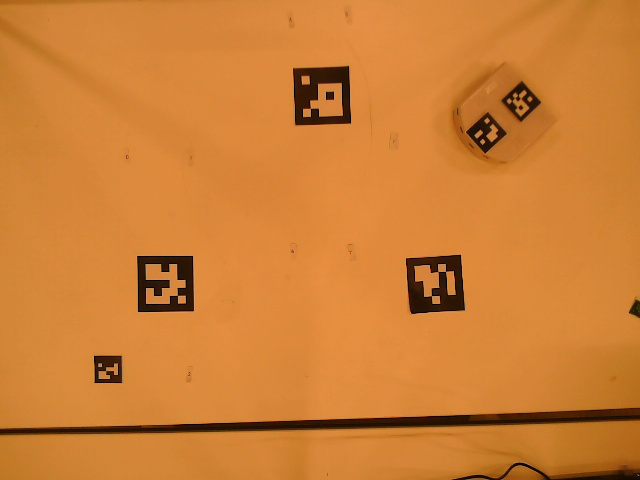

640
480


In [121]:
from PIL import Image

from dijkstar import Graph, find_path
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt


path="images/current.jpg"
display(Image.open(path))

filepath = "images/current.jpg"
img = Image.open(filepath) 
  
# get width and height 
width = img.width 
height = img.height

print(width)
print(height)

In [122]:
obs_nbr = len(obstacle_coord)
node_coord_x=[]
node_coord_y=[]
max_coord_y=height

import math

def distance(node1,node2):
    distance=math.sqrt((node_coord_x[node2]-node_coord_x[node1])**2+(node_coord_y[node2]-node_coord_y[node1])**2)
    distance=round(distance,2)
    return distance
def distance_goal_node(goal,node):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance

def distance_node_goal(node,goal):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance


for obstacle in range(obs_nbr):
    for corner_high in range(2):
        node_coord_y.append(obstacle_coord[obstacle][(2*corner_high)+1]/2)
        node_coord_x.append(obstacle_coord[obstacle][(2*corner_high)])
    for corner_low in range(2):
        node_coord_y.append(max_coord_y-((max_coord_y-obstacle_coord[obstacle][(2*corner_low)+5])/2))
        node_coord_x.append(obstacle_coord[obstacle][(2*corner_low)+4])

def draw_graph(graph_data):
    # Créer un objet Graph avec networkx
    G = nx.Graph()

    # Ajouter des nœuds et des liens au graphique
    for node, edges in graph_data.items():
        G.add_node(node)
        for neighbor, weight in edges.items():
            G.add_edge(node, neighbor, weight=weight)

    # Dessiner le graphique
    pos = nx.spring_layout(G)  # position des nœuds pour un aspect plus lisible
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Afficher le graphique
    plt.show()

graph = Graph ()
def connect_nodes(obs_nbr):     
    for nb_node in range(obs_nbr*4-1):
        if nb_node % 2 == 0:
            graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))
            if nb_node > 3:
                graph.add_edge(nb_node, nb_node -3, distance(nb_node, nb_node -3))
                if nb_node % 4 == 0:
                    graph.add_edge(nb_node, nb_node - 1, distance(nb_node, nb_node - 1))
                else:
                    graph.add_edge(nb_node, nb_node - 5, distance(nb_node, nb_node - 5))
        else:
            graph.add_edge(nb_node, nb_node - 1, distance(nb_node, nb_node - 1))
            if nb_node < (obs_nbr-1)*4:
                graph.add_edge(nb_node, nb_node + 3, distance(nb_node, nb_node + 3))
                if (nb_node-1) % 4 == 0:
                    graph.add_edge(nb_node, nb_node + 5, distance(nb_node, nb_node + 5))
                else:
                    graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))
                    
    # draw_graph(graph)
    # shortest_path = find_path(graph, 0, 2)
    # print(shortest_path)   
    # return graph


[520.5, 107.5]
[101.5, 369.0]
6
break
0 0
0


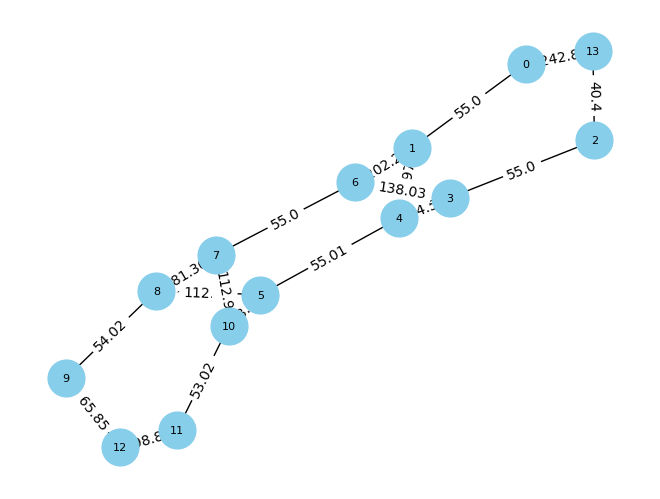

PathInfo(nodes=[12, 9, 8, 7, 6, 3, 2, 13], edges=[65.85, 54.02, 181.36, 55.0, 138.03, 55.0, 40.4], costs=[65.85, 54.02, 181.36, 55.0, 138.03, 55.0, 40.4], total_cost=589.66)


In [123]:
goal_coord_x=[center_thymio[0][0],center_goal[0]]   
print(goal_coord_x)
goal_coord_y=[center_thymio[0][1],center_goal[1]]
print(goal_coord_y)
thymio=100
goal=101
offset=obs_nbr*4

def localisation(object):
    column=0
    break_flag=0
    for obstacle in range(obs_nbr):
        for corner in range(2):
            
            if goal_coord_x[object]<obstacle_coord[obstacle][(2*corner)]:
                print("break")
                print(obstacle,corner)
                break_flag=1
                break
            column+=1
        if break_flag==1:
            break
            
    print(column)
    if column % 2 == 0:
    
        if column < 2 * obs_nbr:
            graph.add_edge(object + offset, 2 * column, distance_goal_node(object, 2 * column))
            graph.add_edge(2 * column, object + offset, distance_node_goal(2 * column, object))

            graph.add_edge(object + offset, 2 * column + 2, distance_goal_node(object, 2 * column + 2))
            graph.add_edge(2 * column + 2, object + offset, distance_node_goal(2 * column + 2, object))
    
        if column > 0:
            graph.add_edge(object + offset, 2 * column - 1, distance_goal_node(object, 2 * column - 1))
            graph.add_edge(2 * column - 1, object + offset, distance_node_goal(2 * column - 1, object))

            graph.add_edge(object + offset, 2 * column - 3, distance_goal_node(object, 2 * column - 3))
            graph.add_edge(2 * column - 3, object + offset, distance_node_goal(2 * column - 3, object))
  
    else:
        if goal_coord_y[object] < obstacle_coord[math.floor((column - 1) / 2)][1]:
            graph.add_edge(object + offset, (2 * column) - 1, distance_goal_node(object, (2 * column) - 1))
            graph.add_edge((2 * column) - 1, object + offset, distance_node_goal((2 * column) - 1, object))

            graph.add_edge(object + offset, (2 * column) - 2, distance_goal_node(object, (2 * column) - 2))
            graph.add_edge((2 * column) - 2, object + offset, distance_node_goal((2 * column) - 2, object))
        else:
            graph.add_edge(object + offset, (2 * column), distance_goal_node(object, (2 * column)))
            graph.add_edge((2 * column), object + offset, distance_node_goal((2 * column), object))

            graph.add_edge(object + offset, (2 * column) + 1, distance_goal_node(object, (2 * column) + 1))
            graph.add_edge((2 * column) + 1, object + offset, distance_node_goal((2 * column) + 1, object))

connect_nodes(obs_nbr)
localisation(0)
localisation(1)

draw_graph(graph)
shortest_path = find_path(graph, 12, 13)
print(shortest_path)
            


In [72]:
print(graph)

{0: {1: 55.0}, 1: {0: 55.0, 4: 139.11, 6: 204.08, 13: 195.54}, 2: {3: 55.0}, 3: {2: 55.0, 6: 139.18, 4: 375.13, 13: 94.03}, 4: {5: 55.0, 1: 139.11, 13: 286.57}, 5: {4: 55.0, 8: 111.14, 10: 368.09}, 6: {7: 54.01, 3: 139.18, 13: 54.69}, 7: {6: 54.01, 10: 112.36, 8: 180.58}, 8: {9: 54.04, 5: 111.14, 12: 42.43}, 9: {8: 54.04, 12: 14.42}, 10: {11: 53.01, 7: 112.36}, 12: {9: 14.42, 8: 42.43}, 13: {4: 286.57, 6: 54.69, 3: 94.03, 1: 195.54}}


## Global navigation

In [92]:
clear()

In [ ]:
goal_coord_x[2]=3
goal_coord_y[2]=3
thymio_angle=0
goal_vector=[0,0]
goal_angle=0
error_angle=0
timer_period[0] = 10
distance_to_goal=0
timer_period[1] = 50
angle_threshold=5
speed=100
last_error_angle=0

#PID
rotation_gain=5
derivative_gain=1


def get_angle(y,x):
    angle=math.degrees(math.atan2(y,x))
    return angle
def rotate():
    motor_left_target
    motor_left_target

@onevent
def timer1():
    global goal_vector, node_coord_x,node_coord_y, shortest_path, goal_coord_x,goal_coord_y,goal_angle,thymio_angle,error_angle,distance_to_goal,last_error_angle
    
    for i in range(len(shortest_path[0])-2):
    #thymio coords and angle update here
        goal_vector=[node_coord_x[shortest_path[0][i+1]]-goal_coord_x[0],node_coord_y[shortest_path[0][i+1]]-goal_coord_y[0]]
        goal_angle=get_angle(goal_vector[1],goal_vector[0])
        thymio_angle=get_angle(goal_coord_y[2],goal_coord_x[2])
        error_angle=thymio_angle-goal_angle
        distance_to_goal=distance_goal_node(0,i+1)
      
        if (abs(error_angle)>threshold):
            motor_left_target=error_angle*rotation_gain+(error_angle-last_error_angle)*derivative_gain*timer_period[1]
            motor_left_target=-1*(error_angle*rotation_gain+(error_angle-last_error_angle)*derivative_gain*timer_period[1])
        else:
            motor_left_target=speed
            motor_left_target=speed
            
        if distance_to_goal<distance_threshold:
            break
    






print(goal_angle)
print(thymio_angle)
print(error_angle)